# Animate EMU adjoints

In [82]:
# --------------------
# Importing and set up
# --------------------

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import os
from os.path import join,expanduser
import sys
# identify user's home directory
user_home_dir = expanduser('~')
# import the ECCOv4 py library 
sys.path.insert(0,join(user_home_dir,'ECCOv4-py'))
import ecco_v4_py as ecco
import ecco_v4_py as e4p
import xarray as xr
import cartopy.crs as ccrs
import cmocean
import cartopy.feature as cfeature

In [83]:
# -------------------------
# Dataset and file loading
# -------------------------

# Load ECCO geometry
geom = xr.open_dataset('/efs_ecco/ECCO/V4/r5/netcdf/native/geometry/GRID_GEOMETRY_ECCO_V4r5_native_llc0090.nc')

# Create x and y arrays for plotting
xx = np.array(geom.XC).ravel()
yy = np.array(geom.YC).ravel()

# Define projection
projection = ccrs.NorthPolarStereo(central_longitude=-50.0)

# Define colormap
cmap = cmocean.cm.balance

# Load corner point files for plotting
xg = np.load('/efs_ecco/cwilliam/mcflurrie/adjoint/plotting_xg.npy')
yg = np.load('/efs_ecco/cwilliam/mcflurrie/adjoint/plotting_yg.npy')

In [104]:
# ------------
# Change path
# ------------

base_path = '/efs_ecco/cwilliam/emu_mackenzie/emu_adj_287_287_4_mask3d.-143.0_-130.0_69.0_72.0_20.0_0.0_1/output/'

In [105]:
# ----------------------
# Load adjoint run data
# ----------------------

files = sorted([i for i in sorted(os.listdir(base_path)) if '.data' in i])
files

['adxx_empmr.0000000129.data',
 'adxx_pload.0000000129.data',
 'adxx_qnet.0000000129.data',
 'adxx_qsw.0000000129.data',
 'adxx_saltflux.0000000129.data',
 'adxx_spflx.0000000129.data',
 'adxx_tauu.0000000129.data',
 'adxx_tauv.0000000129.data']

qnet 2.0932653e-07


<Figure size 640x480 with 0 Axes>

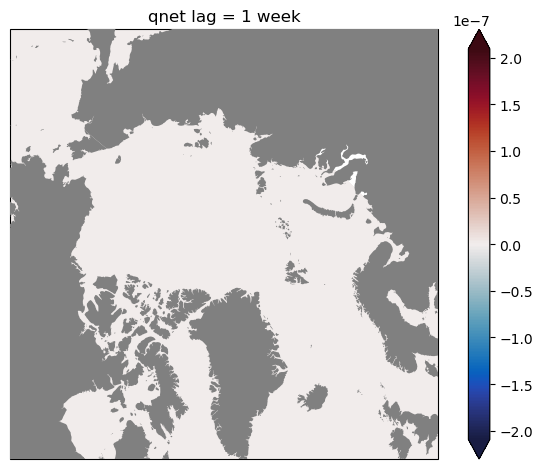

tauu 0.0031688556


<Figure size 640x480 with 0 Axes>

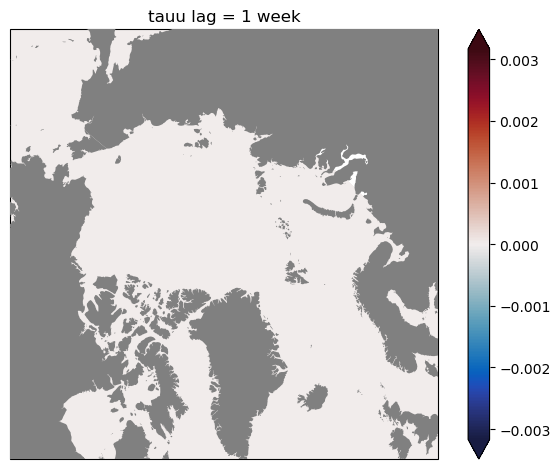

tauv 0.0031224636


<Figure size 640x480 with 0 Axes>

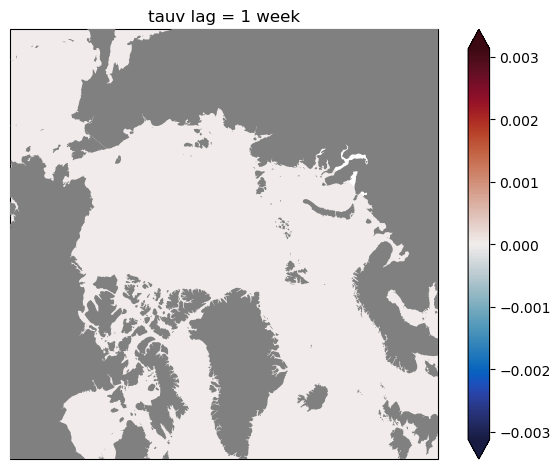

empmr 0.65257996


<Figure size 640x480 with 0 Axes>

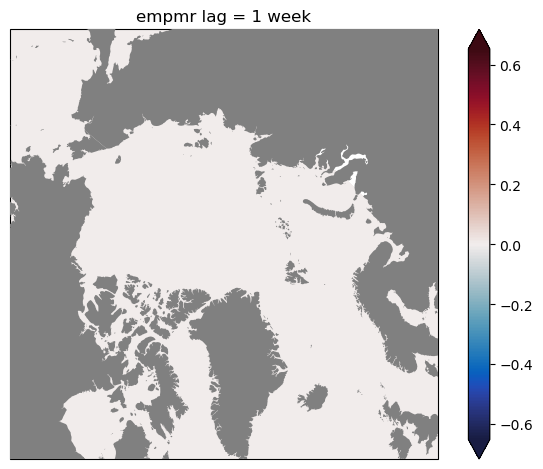

In [107]:
# -----------------------------------------------------
# Create animations for those that are straight output
# -----------------------------------------------------

for name in ['qnet','tauu','tauv', 'empmr']:
    file = [i for i in files if name in i][0]

    adj = np.fromfile(base_path+file,dtype = '>f4').reshape(-1,1170,90)

    adj = e4p.llc_compact_to_tiles(adj,less_output=True)
    sens = adj # (clanky)

    vmax = np.max(np.abs(sens[-50]))*1.
    print(name,vmax)
    plt.clf()
    fig = plt.figure()
    ax = plt.axes(projection = projection)
    it = -1
    pcm2 = plt.pcolormesh(xg[2], yg[2],sens[it,2],transform = ccrs.PlateCarree(),vmax = vmax,vmin = -vmax,cmap = cmap)
    pcm6 = plt.pcolormesh(xg[6], yg[6],sens[it,6],transform = ccrs.PlateCarree(),vmax = vmax,vmin = -vmax,cmap = cmap)
    pcm7 = plt.pcolormesh(xg[7], yg[7],sens[it,7],transform = ccrs.PlateCarree(),vmax = vmax,vmin = -vmax,cmap = cmap)
    pcmx = plt.pcolormesh(xg[10],yg[10],sens[it,10],transform = ccrs.PlateCarree(),vmax = vmax,vmin = -vmax,cmap = cmap)
    plt.title(name+f' lag from November 2015 = {it+1} week')
    plt.colorbar(extend = 'both')
    ax.set_extent((-180,180,60,90),crs = ccrs.PlateCarree())
    ax.add_feature(cfeature.LAND,facecolor = 'grey',zorder = 10)
    plt.tight_layout()

    def update(frame):
        pcm2.set_array(sens[-1-frame,2].ravel())
        pcm6.set_array(sens[-1-frame,6].ravel())
        pcm7.set_array(sens[-1-frame,7].ravel())
        pcmx.set_array(sens[-1-frame,10].ravel())
        ax.set_title(name+f' lag = {frame+1} week')
        return pcm2, pcm6, pcmx

    ani = animation.FuncAnimation(
        fig, update, frames=50, blit=True, interval=150
    )
    plt.show()

    # Save as a gif
    ani.save(name+'_adj.gif')